In [1]:
using Distributions
using StatPlots
using Plots
pyplot()

Plots.PyPlotBackend()

In [2]:
include("src/NGSIM.jl")

chmm_em! (generic function with 1 method)

In [108]:
K = 3
D = 2

# doesn't line up in format with NGSIM data (specifically, no time/frame aspect)
model = rand_chmm(K, D)
(X, Z, traj_ptr, traj_pairs_full) = rand_trajs(model, 
    T_range=500:1_000, N_pairs=250)
num_trajs = length(traj_ptr) - 1
num_obs = size(X, 2)

369688

In [110]:
# make fake data like NGSIM
r = zeros(num_obs)
c = zeros(num_obs)

T = 0
for (i, (i1, i2)) in enumerate(traj_pairs_full)
    s1 = traj_ptr[i1]
    e1 = traj_ptr[i1+1]-1
    
    s2 = traj_ptr[i2]
    e2 = traj_ptr[i2+1]-1
    
    @assert (e2-s2) == (e1-s1)
    dT = length(s2:e2)
    
    r[s1:e1] = T+(1:dT)
    r[s2:e2] = T+(1:dT)
    T += dT
    
    i = sub2ind((2, num_trajs), 1, i)
    c[s1:e1] = i
    c[s2:e2] = i+1
end

S = sparse(r, c, X[1,:])

@assert all(S.colptr .== traj_ptr)

num_pairs = round(Int, length(traj_pairs_full) / 1)
pairs = zeros(Int, 4, num_pairs)
for (i, ind) in enumerate(randperm(length(traj_pairs_full))[1:num_pairs])
    c1, c2 = traj_pairs_full[ind]
    pairs[1:2, i] = [c1, c2]
    pairs[3, i] = S.rowval[traj_ptr[c1]] + rand(1:10)
    pairs[4, i] = S.rowval[traj_ptr[c1+1]-1] - rand(1:10)
end

## EM

In [111]:
curr = chmm_from_data(X, K)
suff = ChmmSuffStats(curr)
;


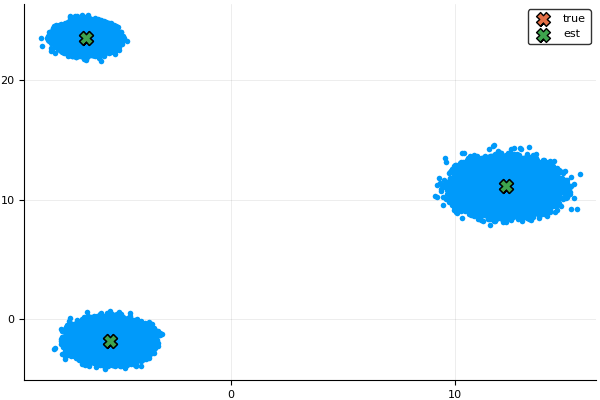

In [113]:
mhat = hcat(curr.μs...)'
m = hcat(model.μs...)'
scatter(X[1, :], X[2, :], label="", marker=(:circle, stroke(0)))
scatter!(m[:, 1], m[:, 2], marker=:X, ms=10, label="true")
scatter!(mhat[:,1], mhat[:, 2], marker=:X, ms=10, label="est")

In [209]:
true_to_est = empty(Int, K)
for i in 1:K
    m = model.μs[i]
    r = map(mm -> norm(m .- mm), curr.μs)
    true_to_est[i] = indmin(r)
end
true_to_est_full = [sub2ind((K, K), i, j) for j in true_to_est for i in true_to_est]
;

In [154]:
KK = K^2
traj_ptr = S.colptr
num_trajs = length(traj_ptr) - 1
num_pairs = size(pairs, 2)

log_p0 = log.(curr.π0)
log_P = log.(curr.P)

T_max = maximum(diff(traj_ptr))

log_b = empty(KK, T_max)
log_α = similar(log_b)
log_β = similar(log_b)
γ = similar(log_b)

log_like = 0.0
zero!(suff)

normals = [ MvNormal(curr.μs[i], curr.Σs[i]) for i in 1:K ]
;

In [181]:
ns = [ MvNormal(model.μs[i], model.Σs[i]) for i in 1:K ]
;

In [155]:
# c1, c2, start_frame, end_frame = pairs[:, e]
c1, c2, start_frame, end_frame = 1, 2, 1, traj_ptr[2]-1
X1 = get_trajectory_from_frame(S, X, c1, start_frame, end_frame)
X2 = get_trajectory_from_frame(S, X, c2, start_frame, end_frame)

Z1 = Z[sp_sub2ind(S, start_frame, c1):sp_sub2ind(S, end_frame, c1)]
Z2 = Z[sp_sub2ind(S, start_frame, c2):sp_sub2ind(S, end_frame, c2)]
W = map((a, b) -> sub2ind((K, K), a, b), Z1, Z2)
;

In [212]:
sum( full(S[start_frame:end_frame, [c1, c2]]) .- [X1[1, :] X2[1, :]] )

0.0

In [214]:
data_likelihood!(PairwiseTrajectory, normals, X1, X2, log_b)
sum( true_to_est_full[W[t]] - indmax(log_b[:, t]) for t in 1:T )

0

In [219]:
log_like = forward_backward!(curr, T, log_p0, log_P, log_b, log_α, log_β, γ)
(log_like, sum( true_to_est_full[W[t]] - indmax(γ[:, t]) for t in 1:T ))

(-6746.056793906571, 0)

In [232]:
zero!(suff)
update_suff_stats!(PairwiseTrajectory, suff, X2, X2, log_p0, log_P, log_b, log_α, log_β, γ)

In [239]:
ctr = DataStructures.counter(true_to_est[[Z1; Z2]])
sum(ctr[i] - suff.counts_K[i] for i in 1:K)

0.0

In [242]:
ctr = DataStructures.counter(true_to_est_full[W])
sum(ctr[i] - suff.counts_KK[i] for i in 1:KK)

0.0

 --------------------------------

______________________________________________________________________

In [93]:
(curr, log_like_hist) = chmm_em!(S, X, pairs, K, curr, suff; N_iters=10, print_every=1)
;

iteration      1:  -1361814.543
iteration      2:  -1237279.793
iteration      3:  -1237022.683
iteration      4:  -1236847.017
iteration      5:  -1236716.983
iteration      6:  -1236614.080
iteration      7:  -1236527.660
iteration      8:  -1236451.384
iteration      9:  -1236381.428
iteration     10:  -1236315.522



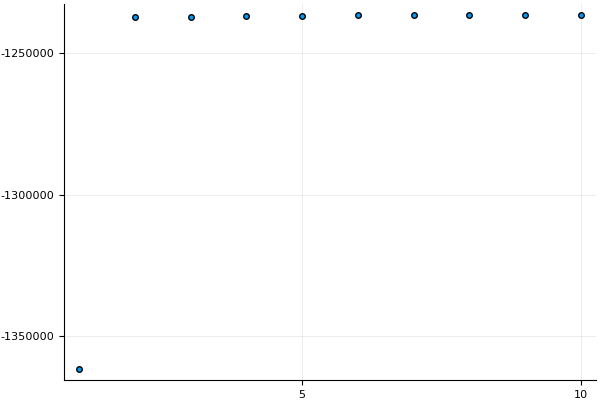

In [94]:
scatter(log_like_hist, legend=false)


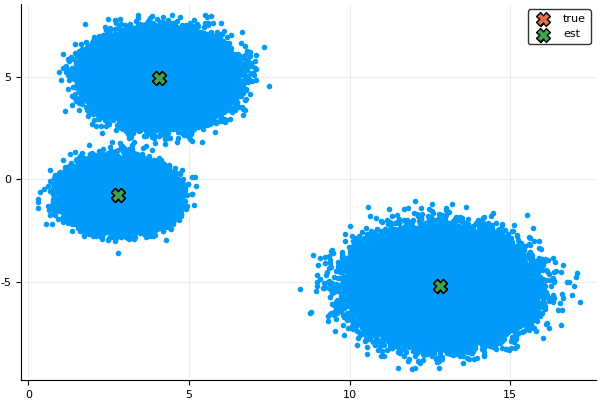

In [95]:
mhat = hcat(curr.μs...)'
m = hcat(model.μs...)'
scatter(X[1, :], X[2, :], label="", marker=(:circle, stroke(0)))
scatter!(m[:, 1], m[:, 2], marker=:X, ms=10, label="true")
scatter!(mhat[:,1], mhat[:, 2], marker=:X, ms=10, label="est")

# Analysis

In [96]:
true_to_est = empty(Int, K)
for i in 1:K
    m = model.μs[i]
    r = map(mm -> norm(m .- mm), curr.μs)
    true_to_est[i] = indmin(r)
end
true_to_est_full = vec(outer(true_to_est))
;

## transition

In [97]:
#
# factor true dist
#

P_true = copy(model.P)
P_single = zeros(K, K, K)

for i in 1:K
    for j in 1:i
        k = sub2ind((K, K), i, j)
        A = square_view(P_true, K, :, k)
        p1, p2 = estimate_outer_double(A)
        
        P_single[:, i, j] = p1        
        P_single[:, j, i] = p2
    end
end

In [98]:
#
# factor est
#

P_hat = curr.P[true_to_est_full, true_to_est_full]
P_single_hat = zeros(K, K, K)

for i in 1:K
    for j in 1:i
        k1 = sub2ind((K, K), i, j)
        k2 = sub2ind((K, K), j, i)
        A = square_view(P_hat, K, :, k1) + square_view(P_hat, K, :, k1)'
        p1, p2 = estimate_outer_double(A)
        
        P_single_hat[:, i, j] = p1        
        P_single_hat[:, j, i] = p2
    end
end

In [99]:
# full
(mean(P_true .- P_hat), std(P_true .- P_hat))

(-0.002519387030511189, 0.13212391412556473)

In [100]:
# factored
(mean(P_single .- P_single_hat), std(P_single .- P_single_hat))

(-2.05596856412066e-18, 0.24325774344383402)


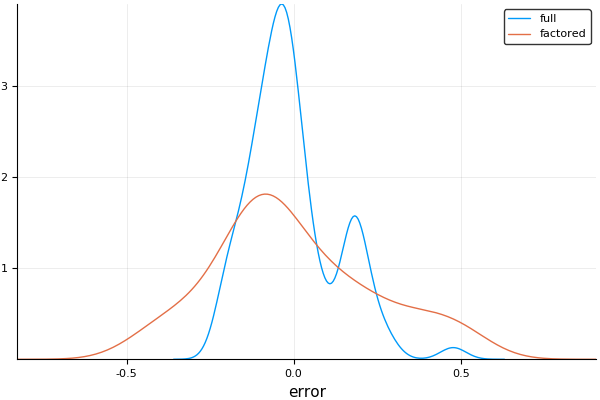

In [101]:
plot(vec(P_true .- P_hat), seriestype=:density, label="full")
plot!(vec(P_single .- P_single_hat), seriestype=:density, label="factored", xlabel="error")

## initial

In [102]:
p0_true = copy(model.π0)
p0_hat = copy( curr.π0[true_to_est_full] )
(mean(p0_true .- p0_hat), std(p0_true .- p0_hat))

(-0.00807372209105469, 0.042569514947942685)


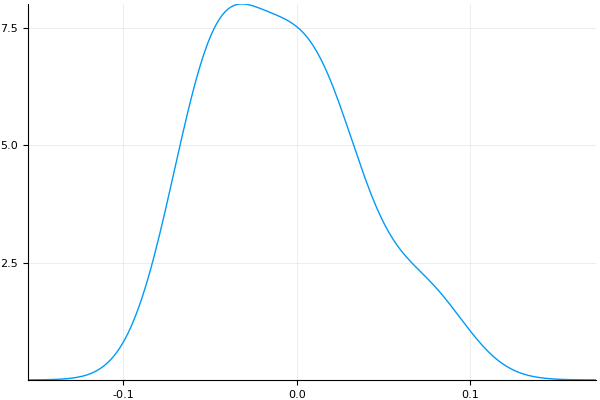

In [103]:
plot(vec(p0_true .- p0_hat), seriestype=:density, legend=false)

## μs

In [104]:
m_errs = [vec((model.μs[i] .- curr.μs[true_to_est[i]])./model.μs[i]) for i in 1:K]
hcat(m_errs ...)

2×3 Array{Float64,2}:
  0.000226287   0.000240769  0.000615325
 -0.000920982  -0.000564722  0.00195194 


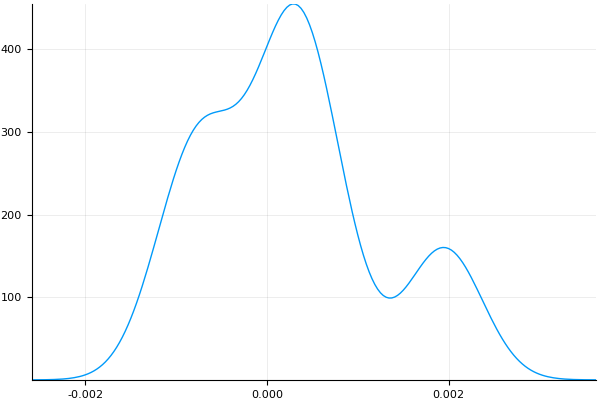

In [105]:
plot(vcat(m_errs...), seriestype=:density, legend=false)

## Σs

In [106]:
S_errs = [vec( model.Σs[i] .- curr.Σs[true_to_est[i]] ) for i in 1:K]
[map(mean, S_errs) map(std, S_errs)]

3×2 Array{Float64,2}:
 -0.00147905   0.00536006 
  0.00265762   0.0009444  
 -0.000450445  0.000234143


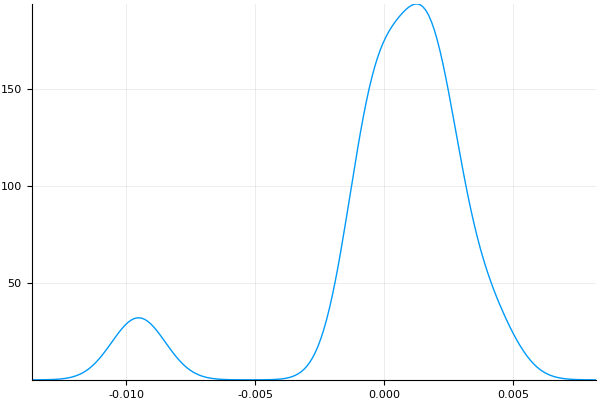

In [107]:
plot(vcat(S_errs...), seriestype=:density, legend=false)